# Decision Tree Lab

In [2]:
pip install arff

  Created wheel for arff: filename=arff-0.9-cp37-none-any.whl size=4970 sha256=742b239cd187e3112190c9fee00e58255a2f0b984bb926e9c399902818596d97
  Stored in directory: /root/.cache/pip/wheels/04/d0/70/2c73afedd3ac25c6085b528742c69b9587cbdfa67e5194583b
Successfully built arff


In [77]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import uuid
import arff as arf
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import graphviz

## 1. (40%) Correctly implement the ID3 decision tree algorithm, including the ability to handle unknown attributes (You do not need to handle real valued attributes).  
### Code Requirements/Notes:
- Use standard information gain as your basic attribute evaluation metric.  (Note that normal ID3 would usually augment information gain with gain ratio or some other mechanism to penalize statistically insignificant attribute splits. Otherwise, even with approaches like pruning below, the SSE type of overfit could still hurt us.) 
- You are welcome to create other classes and/or functions in addition to the ones provided below. (e.g. If you build out a tree structure, you might create a node class).
- It is a good idea to use a simple data set (like the lenses data or the pizza homework), which you can check by hand, to test your algorithm to make sure that it is working correctly. 

In [4]:
class Node():
    def __init__(self, data, labels, feat=None, val=None):
        if len(data) != len(labels):
            raise ValueError("Error: number of instances does not match number of labels")
        self.data = data
        self.labels = labels
        self.feat = feat
        self.val = val
        self.id = uuid.uuid4()
        self.children_ids = []
    
    def avalable_feats(self, used_feats):
        all_feats = [self.feat]
        all_feats.extend(used_feats)
        feats = np.arange(len(self.data[0]))
        return feats[~np.isin(feats, all_feats)]

    def info(self):
        summation = 0
        n = len(self.labels)
        for val in np.unique(self.labels):
            prob = len(self.labels[self.labels == val]) / n
            if prob > 1e-5:
                summation += prob * np.log2(prob)
        return -summation
    
    def make_child(self, feat, val):
        sieve = self.data[:,feat] == val
        return Node(self.data[sieve], self.labels[sieve], feat, val)
    
    def majority(self):
        return np.bincount(self.labels).argmax()

In [5]:
class Tree():
    def __init__(self, root):
        self.nodes = {}
        self.root = root
        self.push(root)

    def push(self, node):
        self.nodes[node.id] = node
    
    def view(self):
        self.view_helper(self.root, -1)

    def view_helper(self, node, layer):
        if node.feat is not None:
            print((" " * 4 * layer) + "feature_" + str(node.feat), "=", node.val)
        if len(node.children_ids) == 0:
            print((" " * 4 * (layer + 1)) + "prediction:", node.majority())
        else:
            for child_id in node.children_ids:
                child = self.nodes[child_id]
                self.view_helper(child, layer + 1)

In [21]:
class DTClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, counts=None):
        """ Initialize class with chosen hyperparameters.
        Args:
        Optional Args (Args we think will make your life easier):
            counts: A list of Ints that tell you how many types of each feature there are
        Example:
            DT  = DTClassifier()
            or
            DT = DTClassifier(count = [2,3,2,2])
            Dataset = 
            [[0,1,0,0],
            [1,2,1,1],
            [0,1,1,0],
            [1,2,0,1],
            [0,0,1,1]]

        """
        self.counts = counts

    def fit(self, X, y):
        """ Fit the data; Make the Decision tree

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 1D numpy array with the training targets

        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        root = Node(X, y)
        self.tree = Tree(root)
        self.split_gains = []
        self.partition_node(root)

        return self

    def partition_node(self, node, used_feats=[]):
        avalable_feats = node.avalable_feats(used_feats)
        # Make sure there are still feature to split on
        if len(avalable_feats) == 0:
            return

        # Find the best feature to split on using gain as the metric
        n = len(node.data)
        info = node.info()
        scores, children = {}, {}
        for i in avalable_feats:
            feature_info = 0
            feature_children = []
            for val in np.unique(node.data[:,i]):
                child = node.make_child(i, val)
                feature_children.append(child)
                m = len(child.data)
                feature_info += (m/n) * child.info()
            # Keep track of child nodes and gain
            children[i] = feature_children
            scores[i] = info - feature_info
        
        # Find feature that maximizes gain
        best_feature = max(scores, key=scores.get)
        gain = scores[best_feature]
        if gain < 1e-5:
            return
        self.split_gains.append(gain)

        # Add nodes to tree and call partition on them
        for leaf in children[best_feature]:
            self.tree.push(leaf)
            node.children_ids.append(leaf.id)
            self.partition_node(leaf, [leaf.feat])

    def view_tree(self):
        self.tree.view()

    def predict(self, X):
        """ Predict all classes for a dataset X

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets

        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        return np.array([self.single_predict(pattern) for pattern in X])

    def single_predict(self, x):
        current_node = self.tree.root
        while len(current_node.children_ids) > 0:
            found = False
            for id in current_node.children_ids:
                child = self.tree.nodes[id]
                if x[child.feat] == child.val:
                    current_node = child
                    found = True
                    break
            if not found:
                break
        return current_node.majority()

    def score(self, X, y):
        """ Return accuracy(Classification Acc) of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 1D numpy array of the targets 
        """
        predictions = self.predict(X)
        correct = sum([1 for i, z in enumerate(predictions) if z == y[i]])
        return correct / len(y)


## 1.1 Debug

Debug your model by training on the lenses dataset: [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses.arff)

Test your model on the lenses test set: [Debug Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses_test.arff)

Parameters:
(optional) counts = [3,2,2,2] (You should compute this when you read in the data, before fitting)

---

Expected Results: Accuracy = [0.33]

Predictions should match this file: [Lenses Predictions](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/pred_lenses.csv)

*NOTE: The [Lenses Prediction](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/pred_lenses.csv) uses the following encoding: soft=2, hard=0, none=1. If your encoding is different, then your output will be different, but not necessarily incorrect.*

Split Information Gains (These do not need to be in this exact order):

[0.5487949406953987, 0.7704260414863775, 0.3166890883150208, 1.0, 0.4591479170272447, 0.9182958340544894]

<!-- You should be able to get about 68% (61%-82%) predictive accuracy on the lenses data -->

Here's what your decision tree splits should look like, and the corresponding child node predictions:

Decision Tree:
<pre>
feature_3 = 0:
	feature_2 = 0:
		feature_0 = 0:
			prediction: 2
		feature_0 = 1:
			feature_1 = 0:
				prediction: 2
			feature_1 = 1:
				prediction: 1
		feature_0 = 2:
			prediction: 2
	feature_2 = 1:
		feature_1 = 0:
			feature_0 = 0:
				prediction: 1
			feature_0 = 1:
				prediction: 1
			feature_0 = 2:
				prediction: 0
		feature_1 = 1:
			prediction: 0
feature_3 = 1:
	prediction: 1
</pre>

In [22]:
# Load debug training data 
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses.arff --output lenses.arff &> /dev/null
lenses_data = arff.loadarff("lenses.arff")

# Encode categorical to numeric
lenses_df = pd.DataFrame(lenses_data[0])
lenses_df = lenses_df.apply(LabelEncoder().fit_transform)
lenses_np = np.array(lenses_df)
# Split off labels
lenses_x, lenses_y = lenses_np[:,:-1], lenses_np[:,-1]

# Train Decision Tree
lenses_DT = DTClassifier()
lenses_DT.fit(lenses_x, lenses_y)
lenses_DT.view_tree()

# Load debug test data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses_test.arff --output lenses_test.arff &> /dev/null
lenses_test_data = arff.loadarff("lenses_test.arff")

# Encode categorical to numeric
lenses_test_df = pd.DataFrame(lenses_test_data[0])
lenses_test_df = lenses_test_df.apply(LabelEncoder().fit_transform)
lenses_test_np = np.array(lenses_test_df)
# Split off labels
lenses_test_x, lenses_test_y = lenses_test_np[:,:-1], lenses_test_np[:,-1]

# Predict and compute model accuracy
accuracy = lenses_DT.score(lenses_test_x, lenses_test_y)
print("Accuracy:", round(accuracy, 2))

# Print the information gain of every split you make.
print(lenses_DT.split_gains)

feature_3 = 0
    feature_2 = 0
        feature_0 = 0
            prediction: 2
        feature_0 = 1
            feature_1 = 0
                prediction: 2
            feature_1 = 1
                prediction: 1
        feature_0 = 2
            prediction: 2
    feature_2 = 1
        feature_1 = 0
            feature_0 = 0
                prediction: 1
            feature_0 = 1
                prediction: 1
            feature_0 = 2
                prediction: 0
        feature_1 = 1
            prediction: 0
feature_3 = 1
    prediction: 1
Accuracy: 0.33
[0.5487949406953982, 0.7704260414863778, 0.3166890883150208, 1.0, 0.4591479170272448, 0.9182958340544896]


In [23]:
# Optional/Additional Debugging Dataset - Pizza Homework
pizza_dataset = np.array([[1,2,0],[0,0,0],[0,1,1],[1,1,1],[1,0,0],[1,0,1],[0,2,1],[1,0,0],[0,2,0]])
pizza_labels = np.array([2,0,1,2,1,2,1,1,0])
pizza_DT = DTClassifier()
pizza_DT.fit(pizza_dataset, pizza_labels)
pizza_DT.view_tree()

feature_0 = 0
    feature_2 = 0
        prediction: 0
    feature_2 = 1
        prediction: 1
feature_0 = 1
    feature_1 = 0
        feature_2 = 0
            prediction: 1
        feature_2 = 1
            prediction: 2
    feature_1 = 1
        prediction: 2
    feature_1 = 2
        prediction: 2


## 1.2 Evaluation

We will evaluate your model based on its performance on the zoo dataset. 

Train your model using this dataset: [Evaluation Train Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo.arff)

Test your model on this dataset: [Evaluation Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo_test.arff)

Parameters:
(optional) counts = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2] (You should compute this when you read in the data, before fitting)

---
Print out your accuracy on the evaluation test dataset.

Print out the information gain of every split you make.

In [24]:
# Load evaluation training data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo.arff --output zoo.arff &> /dev/null
zoo_data = arff.loadarff("zoo.arff")

# Encode categorical to numeric
zoo_df = pd.DataFrame(zoo_data[0])
zoo_df = zoo_df.apply(LabelEncoder().fit_transform)
zoo_np = np.array(zoo_df)
# Split off labels
zoo_x, zoo_y = zoo_np[:,:-1], zoo_np[:,-1]

# Train Decision Tree
zoo_DT = DTClassifier()
zoo_DT.fit(zoo_x, zoo_y)
zoo_DT.view_tree()

# Load evaluation test data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo_test.arff --output zoo_test.arff &> /dev/null
zoo_test_data = arff.loadarff("zoo_test.arff")

# Encode categorical to numeric
zoo_test_df = pd.DataFrame(zoo_test_data[0])
zoo_test_df = zoo_test_df.apply(LabelEncoder().fit_transform)
zoo_test_np = np.array(zoo_test_df)
# Split off labels
zoo_test_x, zoo_test_y = zoo_test_np[:,:-1], zoo_test_np[:,-1]

# Predict and compute model accuracy
accuracy = zoo_DT.score(zoo_test_x, zoo_test_y)
print("Accuracy:", round(accuracy, 2))

# Print out the information gain for every split you make
print(zoo_DT.split_gains)

feature_12 = 0
    feature_11 = 0
        feature_7 = 0
            prediction: 5
        feature_7 = 1
            prediction: 1
    feature_11 = 1
        feature_2 = 0
            prediction: 6
        feature_2 = 1
            prediction: 2
feature_12 = 1
    feature_0 = 0
        prediction: 0
    feature_0 = 1
        prediction: 6
feature_12 = 2
    feature_0 = 0
        feature_5 = 0
            prediction: 1
        feature_5 = 1
            feature_7 = 0
                prediction: 5
            feature_7 = 1
                prediction: 3
    feature_0 = 1
        prediction: 6
feature_12 = 3
    prediction: 5
feature_12 = 4
    feature_5 = 0
        prediction: 4
    feature_5 = 1
        prediction: 5
feature_12 = 5
    prediction: 5
Accuracy: 0.15
[1.3630469031539394, 0.8865408928220899, 0.9852281360342515, 0.6962122601251459, 0.8256265261578954, 0.6892019851173656, 0.8631205685666308, 0.7219280948873623, 0.7219280948873623]


## 2. (20%) You will use your ID3 algorithm to induce decision trees for the cars dataset and the voting dataset.  Do not use a stopping criteria, but induce the tree as far as it can go (until classes are pure or there are no more data or attributes to split on).  
- Implement and use 10-fold Cross Validation (CV) on each data set to predict how well the models will do on novel data.  
- For each dataset, report the training and test classification accuracy for each fold and the average test accuracy. 
- As a rough sanity check, typical decision tree accuracies for these data sets are: Cars: .90-.95, Vote: .92-.95.

## 2.1 Implement 10-fold Cross Validation

In [94]:
# Write a function that implements 10-fold cross validation
def cross_val(data):
    np.random.shuffle(data)

    k = 10
    n = len(data)
    part = n // k
    test_accs = []
    DT = None
    for i in range(k):
        mask = np.ones(len(data), dtype=bool)
        mask[(i * part):((i + 1) * part)] = False

        test, val = data[mask], data[~mask]

        DT = DTClassifier()
        DT.fit(test[:,:-1], test[:,-1])
        train_acc = DT.score(test[:,:-1], test[:,-1])
        test_acc = DT.score(val[:,:-1], val[:,-1])
        test_accs.append(test_acc)
        print("Partition #" + str(i+1) + ": train acc:", train_acc, "| test acc:", test_acc)
    print("Average test acc", sum(test_accs) / k)
    return DT

##  2.2 Cars Dataset
- Use this [Cars Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/cars.arff)
- Make a table for your K-Fold cross validation accuracies

*If you are having trouble using scipy's loadarff function (scipy.io.arff.loadarff), try:*

*pip install arff &nbsp;&nbsp;&nbsp;&nbsp;          # Install arff library*

*import arff as arf*                   

*cars = list(arf.load('cars.arff'))   &nbsp;&nbsp;&nbsp;&nbsp;# Load your downloaded dataset (!curl, etc.)*

*df = pd.DataFrame(cars)*  

*There may be additional cleaning needed*

In [95]:
# Use 10-fold CV on Cars Dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/cars.arff --output cars.arff &> /dev/null
cars_data = list(arf.load("cars.arff")) # arff.loadarff("cars.arff")

# Encode categorical to numeric
cars_df = pd.DataFrame(cars_data)
cars_df = cars_df.apply(LabelEncoder().fit_transform)
cars_np = np.array(cars_df)

# Report Training and Test Classification Accuracies
# Report Average Test Accuracy
dt = cross_val(cars_np)
dt.view_tree()

Partition #1: train acc: 1.0 | test acc: 0.9534883720930233
Partition #2: train acc: 1.0 | test acc: 0.9476744186046512
Partition #3: train acc: 1.0 | test acc: 0.9418604651162791
Partition #4: train acc: 1.0 | test acc: 0.9244186046511628
Partition #5: train acc: 1.0 | test acc: 0.9476744186046512
Partition #6: train acc: 1.0 | test acc: 0.9476744186046512
Partition #7: train acc: 1.0 | test acc: 0.9593023255813954
Partition #8: train acc: 1.0 | test acc: 0.9418604651162791
Partition #9: train acc: 1.0 | test acc: 0.9418604651162791
Partition #10: train acc: 1.0 | test acc: 0.9534883720930233
Average test acc 0.9459302325581396
feature_5 = 0
    feature_3 = 0
        prediction: 2
    feature_3 = 1
        feature_0 = 0
            feature_1 = 0
                prediction: 0
            feature_1 = 1
                prediction: 0
            feature_1 = 2
                prediction: 0
            feature_1 = 3
                prediction: 2
        feature_0 = 1
            feature_1 =

## 2.3 Voting Dataset
- Use this [Voting Dataset with missing values](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)
- Note that you will need to support unknown attributes in the voting data set. 

In [96]:
# Used 10-fold CV on Voting Dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff --output voting_with_missing.arff &> /dev/null
voting_data = arff.loadarff("voting_with_missing.arff")

# Encode categorical to numeric
voting_df = pd.DataFrame(voting_data[0])
voting_df = voting_df.apply(LabelEncoder().fit_transform)
voting_np = np.array(voting_df)

# Report Training and Test Classification Accuracies
# Report Average Test Accuracy
dt = cross_val(voting_np)
dt.view_tree()

Partition #1: train acc: 1.0 | test acc: 0.9302325581395349
Partition #2: train acc: 1.0 | test acc: 0.9302325581395349
Partition #3: train acc: 1.0 | test acc: 0.9534883720930233
Partition #4: train acc: 1.0 | test acc: 0.9767441860465116
Partition #5: train acc: 1.0 | test acc: 0.9069767441860465
Partition #6: train acc: 1.0 | test acc: 0.9302325581395349
Partition #7: train acc: 1.0 | test acc: 0.9302325581395349
Partition #8: train acc: 1.0 | test acc: 0.9767441860465116
Partition #9: train acc: 1.0 | test acc: 0.9534883720930233
Partition #10: train acc: 1.0 | test acc: 0.8372093023255814
Average test acc 0.9325581395348838
feature_3 = 0
    feature_8 = 0
        prediction: 1
    feature_8 = 1
        prediction: 0
    feature_8 = 2
        feature_6 = 0
            prediction: 0
        feature_6 = 1
            prediction: 1
        feature_6 = 2
            prediction: 0
feature_3 = 1
    feature_2 = 0
        prediction: 0
    feature_2 = 1
        feature_5 = 0
            p

## 2.4 Discuss Your Results

- Summarize your results from both datasets, and discuss what you observed. 
- A fully expanded tree will often get 100% accuracy on the training set. Why does this happen and in what cases might it not?  

Both the cars and voting classification performed very well at 95% and 93% repectively. The cars classifier varied ~3% across the 10-fold cross-val while the voting classifier varied ~13%.

If a dataset has alot of different features and values for those features, it's possible that no two inputs are exactly the same so each would end up in a node by itself which would have 100% accuracy. In the case when there is sufficient data with catagorical features, this is unlikely to happen.

## 3. (15%) For each of the two problems above, summarize in English what the decision tree has learned (i.e. look at the induced tree and describe what rules it has discovered to try to solve each task). 
- If the tree is very large you can just discuss a few of the more shallow attribute combinations and the most important decisions made high in the tree.

## 3.1 Discuss what the decision tree induced on the cars dataset has learned

The decision tree on the cars dataset learned that the most important features are saftey, # of seating, and buying price. Saftey and # of seating were often enough to provide an accepability classification.

## 3.2 Discuss what the decision tree induced on the voting dataset has learned

The decision tree on the voting dataset learned that the most important features are physician-fee-freeze, mx-missile, adoption-of-the-budget-resolution, and synfuels-corporation-cutback. For example, voters who said no to physician-fee-freeze and mx-missile were classified as republican.

## 3.3 How did you handle unknown attributes in the voting problem? Why did you choose this approach? (Do not use the approach of just throwing out data with unknown attributes).

I made missing values a seperate value in the features with them. Using scikit's label encoder, this was pretty straight-forward. This probably makes more sense in the case of the voting dataset more than the cars but, depending on how the data was collected, a missing attribute may accually have meaning in the context of the problem. For example, it could mean that a voter was indecisive on an issue. This tells us something about them that could have predictive value.

## 4.1 (10%) Use SciKit Learn's decision tree on the voting dataset and compare your results. Try different parameters and report what parameters perform the best on the test set. 

### 4.1.1 SK Learn on Voting Dataset
- Use this [Voting Dataset with missing values](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)

In [90]:
# Use SK Learn's Decision Tree to learn the voting dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff --output voting_with_missing.arff &> /dev/null
voting_data = arff.loadarff("voting_with_missing.arff")

# Encode categorical to numeric
voting_df = pd.DataFrame(voting_data[0])
voting_df = voting_df.apply(LabelEncoder().fit_transform)
voting_np = np.array(voting_df)
# Shuffle data
np.random.shuffle(voting_np)
# Split off test set
part = round(len(voting_np) * .8)
voting_train, voting_test = voting_np[:part], voting_np[part:]
# Split off labels
voting_train_x, voting_train_y = voting_train[:,:-1], voting_train[:,-1]
voting_test_x, voting_test_y = voting_test[:,:-1], voting_test[:,-1]

# Explore different parameters
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[3, 5, 10, 20]}
voting_dt = DecisionTreeClassifier()
clf = GridSearchCV(voting_dt, parameters)
clf.fit(voting_train_x, voting_train_y)

# Report results
print(clf.score(voting_test_x, voting_test_y))
clf.best_estimator_

0.9425287356321839


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

The entropy criterion with max depth of 3 had the best results with the voting dataset. Compared to my classifier, it scored ~1% better.

## 4.2 (10%) Choose a data set of your choice (not already used in this or previous labs) and use the SK decision tree to learn it. Experiment with different hyper-parameters to try to get the best results possible.

In [91]:
# Use SciKit Learn's Decision Tree on a new dataset
!curl https://raw.githubusercontent.com/grantpitt/ml-datasets/master/transfusion.data --output transfusion.data &> /dev/null
autism_data = pd.read_csv("transfusion.data")  # arff.loadarff("Autism_Data.arff")

# Encode categorical to numeric
autism_df = pd.DataFrame(autism_data)

autism_df = autism_df.apply(LabelEncoder().fit_transform)
autism_np = np.array(autism_df)
# Shuffle data
np.random.shuffle(autism_np)
# Split off test set
part = round(len(autism_np) * .8)
autism_train, autism_test = autism_np[:part], autism_np[part:]
# Split off labels
autism_train_x, autism_train_y = autism_train[:,:-1], autism_train[:,-1]
autism_test_x, autism_test_y = autism_test[:,:-1], autism_test[:,-1]

# Explore different parameters
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[3, 5, 10, 20]}
autism_dt = DecisionTreeClassifier()
clf = GridSearchCV(autism_dt, parameters)
clf.fit(autism_train_x, autism_train_y)
print(clf.score(autism_test_x, autism_test_y))

0.7733333333333333


## 5. (5%) Visualize sklearn's decision tree for your chosen data set (using export_graphviz or another tool) and discuss what you find. If your tree is too deep to reasonably fit on one page, show only the first several levels (e.g. top 5).

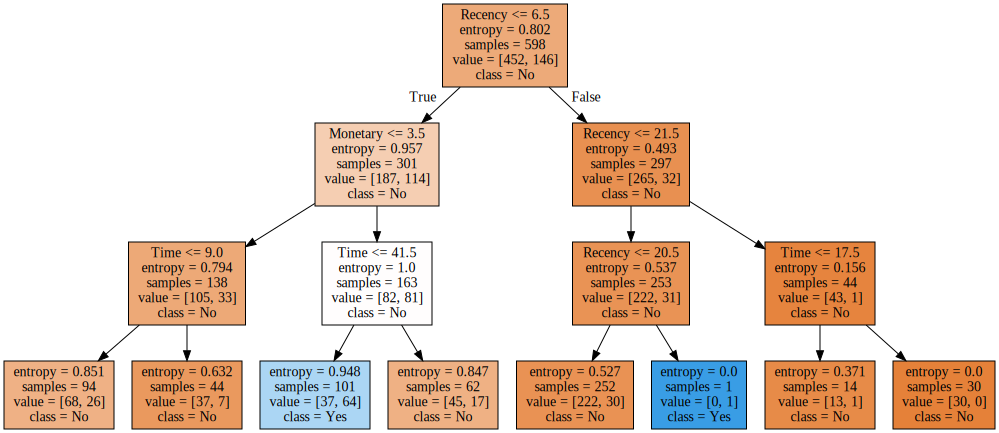

In [93]:
# Include decision tree visualization here
dot_data = tree.export_graphviz(clf.best_estimator_,
                                feature_names=["Recency", "Frequency", "Monetary", "Time"],  
                                class_names=["No", "Yes"],
                                out_file=None, 
                                filled=True, 
                                max_depth=3)
graphviz.Source(dot_data, format="png")

# Discuss what the model has learned
# * See below graph/tree output

So this model was trying to predict whether or not a person donated blood in a particular month based on things like past frequency, recency, time since first donation, and how much they have donated in total.

The model learned that if a person has donated in the last 6.5 months, has donated more than 3.5 times, and donated for the first time less than 3.5 years ago, then they are far more likely to donate that month.

## 6. (optional 5% extra credit) Implement reduced error pruning to help avoid overfitting.  
- You will need to take a validation set out of your training data to do this, while still having a test set to test your final accuracy. 
- Create a table comparing your decision tree implementation's results on the cars and voting data sets with and without reduced error pruning. 
- This table should compare:
    - a) The # of nodes (including leaf nodes) and tree depth of the final decision trees 
    - b) The generalization (test set) accuracy. (For the unpruned 10-fold CV models, just use their average values in the table).